In [9]:
using Turing, Plots, Random, DelimitedFiles, DataFrames

In [10]:
Random.seed!(0);
#Generate data
T = 120

w1, w2, w3 = 0.1, 0.25, 1

x_data = [randn()]
y_data = [x_data[end]+0.1*randn()]
for t=2:25
    append!(x_data, x_data[end] + sqrt(1/w1)*randn())
    append!(y_data, x_data[end] + randn())
end
for t=26:75
    append!(x_data, x_data[end] + sqrt(1/w2)*randn())
    append!(y_data, x_data[end] + randn())
end
for t=76:T
    append!(x_data, x_data[end] + sqrt(1/w3)*randn())
    append!(y_data, x_data[end] + randn())
end

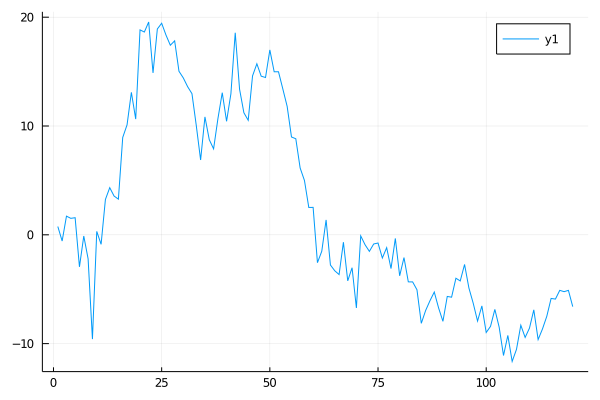

In [11]:
plot(y_data)

In [12]:
@model function SSSM(y)
    vars = [10, 4, 1]
    T = length(y)
    z = tzeros(Int,T-1)
    x = Vector(undef, T)
    M = Vector{Vector}(undef,3) # Transition matrix
    M[1] ~ Dirichlet([100,1,1])
    M[2] ~ Dirichlet([1,100,1])
    M[3] ~ Dirichlet([1,1,100])
    
    z[1] ~ Categorical(3)
    x[1] ~ Normal()
    y[1] ~ Normal(x[1],sqrt(1))
    for t = 2:T-1
        x[t] ~ Normal(x[t-1],sqrt(vars[z[t-1]]))
        y[t] ~ Normal(x[t],sqrt(1))
        z[t] ~ Categorical(vec(M[z[t-1]]))
    end
    x[T] ~ Normal(x[T-1],sqrt(vars[z[T-1]]))
    y[T] ~ Normal(x[T],sqrt(1))
end

SSSM (generic function with 1 method)

In [13]:
gibbs = Gibbs(HMC(0.2,20,:x,:M),PG(50,:z))
chain = sample(SSSM(y_data),gibbs,100)

Sampling: 100%|█████████████████████████████████████████| Time: 0:02:22


Chains MCMC chain (100×249×1 Array{Float64,3}):

Iterations        = 1:100
Thinning interval = 1
Chains            = 1
Samples per chain = 100
parameters        = M[1][1], M[1][2], M[1][3], M[2][1], M[2][2], M[2][3], M[3][1], M[3][2], M[3][3], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11], x[12], x[13], x[14], x[15], x[16], x[17], x[18], x[19], x[20], x[21], x[22], x[23], x[24], x[25], x[26], x[27], x[28], x[29], x[30], x[31], x[32], x[33], x[34], x[35], x[36], x[37], x[38], x[39], x[40], x[41], x[42], x[43], x[44], x[45], x[46], x[47], x[48], x[49], x[50], x[51], x[52], x[53], x[54], x[55], x[56], x[57], x[58], x[59], x[60], x[61], x[62], x[63], x[64], x[65], x[66], x[67], x[68], x[69], x[70], x[71], x[72], x[73], x[74], x[75], x[76], x[77], x[78], x[79], x[80], x[81], x[82], x[83], x[84], x[85], x[86], x[87], x[88], x[89], x[90], x[91], x[92], x[93], x[94], x[95], x[96], x[97], x[98], x[99], x[100], x[101], x[102], x[103], x[104], x[105], x[106], x[107], x[108], 

In [14]:
mean(group(chain,:M).value.data, dims=1)

1×9×1 Array{Float64,3}:
[:, :, 1] =
 0.941438  0.0185159  0.0400459  0.0175207  …  0.024793  0.0118055  0.963401

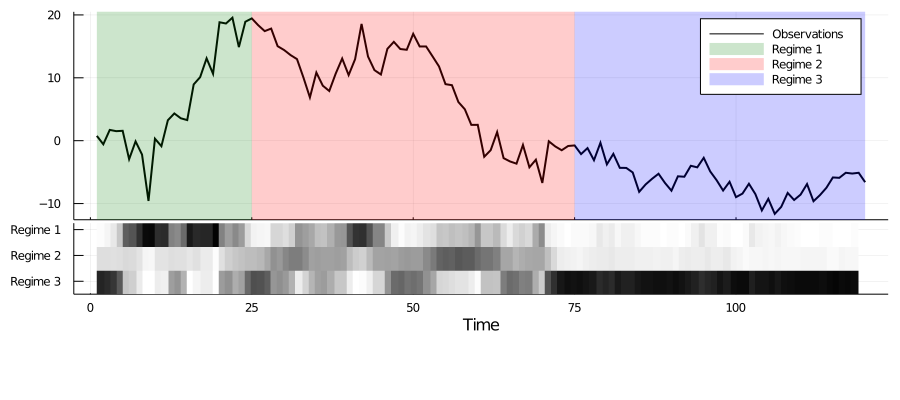

In [15]:
m_z = zeros(3,T-1)
for t=1:T-1
    dd = [(i, count(==(i), group(chain,:z).value.data[:,t])) for i in [1.0,2.0,3.0]]
    num1, num2, num3 = dd[1][2], dd[2][2], dd[3][2]
    num = num1+num2+num3
    m_z[1,t] = num1/num
    m_z[2,t] = num2/num
    m_z[3,t] = num3/num
end

estimate = zeros(12,T-1)
for i=1:4
    estimate[i,:] = 1. .- m_z[1,:]
    estimate[i+4,:] = 1. .- m_z[2,:]
    estimate[i+8,:] = 1. .- m_z[3,:]
end

gr()
l = @layout [a ; b]
mm=Plots.PlotMeasures.mm
p1 = plot(1:T, y_data, w=2, labels = "Observations", legend=(:best), color=:black)
vspan!(p1,[1,25], color = :green, alpha = 0.2, labels = "Regime 1");
vspan!(p1,[25,75], color = :red, alpha = 0.2, labels = "Regime 2");
vspan!(p1,[75,T], color = :blue, alpha = 0.2, labels = "Regime 3");

p2 = plot(Gray.(estimate), link=:x, xlabel="Time", top_margin=-25.0mm)
yticks!([2:4:10;], ["Regime 1", "Regime 2", "Regime 3"])

p = plot(p1, p2, layout = l, size = (900, 400))

In [16]:
writedlm("HMCestimates.txt", estimate)